# LSTM for Predictive Maintenance using FD001 Dataset

This notebook demonstrates how to build a predictive maintenance model using the FD001 dataset from the NASA Turbofan Engine Degradation Simulation Data Set. The objective is to predict the Remaining Useful Life (RUL) of engines based on their sensor readings and operational settings using an LSTM model implemented with TensorFlow/Keras.


# Layers in the Network
## LSTM (Long Short-Term Memory)

LSTM is a type of recurrent neural network (RNN) architecture that is designed to model temporal sequences and their long-range dependencies more accurately than conventional RNNs. LSTMs are well-suited to learn from and make predictions based on sequential data.

An LSTM network consists of LSTM cells. Each LSTM cell has several components:
1. Cell State: The cell state is the memory of the network. It is the key feature of LSTMs that allows them to maintain long-term dependencies.
    - The cell state it updated by combing the previous cell state, modified by the forget gate, and the candidate values, scaled by the input gate.
    - $ C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t $
        - $ C_t $ is the cell state at time step $ t $.
        - $ f_t $ is the forget gate vector.
        - $ C_{t-1} $ is the previous cell state.
        - $ i_t $ is the input gate vector.
        - $ \tilde{C}_t $ is the candidate cell state.
2. Hidden State: The hidden state is the output of the LSTM cell, which can be passed to the next LSTM cell or used to make a prediction. (Refer to Ouput Gate Section)
3. Input Gate: Controls the extent to which new value flows into the cell state.
    - Input Gate Layer: Decides which values to update.
        - $ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $
            - $ i_t $ is the input gate vector at time step $ t $.
            - $ \sigma $ is the sigmoid activation function.
            - $ W_i $ is the weight matrix for the input gate.
            - $ b_i $ is the bias for the input gate.
    - Candidate Layer: Creates a vector of new candidate values.
        - $ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $
            - $ \tilde{C}_t $ is the candidate cell state.
            - $ \tanh $ is the hyperbolic tangent activation function.
            - $ W_C $ is the weight matrix for the candidate layer.
            - $ b_C $ is the bias for the candidate layer.
4. Forget Gate: Decides what information to discard from the cell state.
    - It takes the hidden state from the previous time step and the current input and passes them through a sigmoid function.
    - $ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $
        - $ f_t $ is the forget gate vector at time step $ t $.
        - $ \sigma $ is the sigmoid activation function.
        - $ W_f $ is the weight matrix for the forget gate.
        - $ h_{t-1} $ is the hidden state from the previous time step.
        - $ x_t $ is the input at the current time step.
        - $ b_f $ is the bias for the forget gate.

5. Output Gate: Controls the output from the LSTM cell.
    - Uses the current cell state and passes it through a sigmoid function and a tanh function to determine the next hidden state.
    - $ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $
        - $ o_t $ is the output gate vector at time step $ t $.
        - $ \sigma $ is the sigmoid activation function.
        - $ W_o $ is the weight matrix for the output gate.
        - $ b_o $ is the bias for the output gate.
    - $ h_t = o_t \cdot \tanh(C_t) $
        - $ h_t $ is the hidden state at time step $ t $.
        - $ \tanh $ is the hyperbolic tangent activation function.
        - $ C_t $ is the cell state at time step $ t $.


## Dense Layer

A Dense layer (fully connected layer) is a regular neural network layer where each neuron is connected to every neuron in the previous layer. It applied a linear transformation followed by an activation function.

## Dropout Layer

A Dropout Layer randomly sets a function of input units to 0 at each update during training time, which helps prevent overfitting.

# LSTM Model Step-by-Step
1. Input Sequence: The model receives an input.
2. LSTM Layer: The input sequence is passed through the LSTM layer. The LSTM cells process the input sequentially, maintining and updating the cell state and hidden state. This allows the model to capture temporal dependencies in the data.
    1. Forget State
    2. Input Gate
    3. Update Cell State
    4. Output Gate
3. Dropout Layer: The output from the LSTM layer is passed through a Dropout layer to prevent overfitting by randomly setting some of the activations to zero.
4. Dense Layer: The output from the Dropout layer is passed to the Dense layer, which produces the final prediction.

In [86]:
# Data Loading and Preprocessing
import numpy as np
import pandas as pd

# Normalization
from sklearn.preprocessing import StandardScaler

# Model Training
import tensorflow as tf

# LSTM
from tensorflow.keras.models import Sequential # Linear Stack of Layers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# Input - Specifies input shape of model
# LSTM - Long Short-Term Memory: Type of Recurrent Neural Network (RNN) layer capable of learning long-term dependencies
# Dense - Fully connected layer where each neuron in the layer receives input from all neurons of the previous layer: Output layer
# Dropout - Regularization technique used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training

# Random Forest
# from sklearn.ensemble import RandomForestRegressor # Ensemble learning method that constructs multiple decision trees and outputs the average prediction
# from sklearn.model_selection import train_test_split # Splits the dataset into training and testing/validation sets

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
# Mean Squared Error - Calculates the root mean squared error regression loss to evaluate the performance of the model
# R^2 - Computes the R^2 to evaluate the goodness of fit of the model

# Visualization
import matplotlib.pyplot as plt

In [73]:
# Load data
file_prefix = 'FD001'
train_data_raw = pd.read_csv(f'CMAPSSData/train_{file_prefix}.txt', sep=' ', header=None)
test_data_raw = pd.read_csv(f'CMAPSSData/test_{file_prefix}.txt', sep=' ', header=None)
rul_data_raw = pd.read_csv(f'CMAPSSData/RUL_{file_prefix}.txt', header=None)

In [74]:
# Data Preprocessing - Data Cleaning
train_data = train_data_raw.drop(columns=[26, 27])
test_data = test_data_raw.drop(columns=[26, 27])
rul_data = rul_data_raw.copy(deep=True)

column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
               ['sensor_measurement_' + str(i) for i in range(1, 22)]

train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

# print(train_data.head())
# print(test_data.head())
# print(rul_data.head())

In [75]:
# Data Preprocessing - Normalization
scaler = StandardScaler()
train_data.iloc[:, 5:] = scaler.fit_transform(train_data.iloc[:, 5:])
test_data.iloc[:, 5:] = scaler.transform(test_data.iloc[:, 5:])

In [76]:
# Data Preprocessing - RUL Calculation
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform("max") - train_data['time_in_cycles']

In [77]:
# Data Preprocessing - LSTM Sequences
def prepare_sequences(data, sequence_length=50, include_targets=True):
    sequences = []
    targets = []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit]
        for start in range(len(unit_data) - sequence_length):
            sequences.append(unit_data.iloc[start:start+sequence_length, 3:24].values)
            if include_targets:
                targets.append(unit_data.iloc[start + sequence_length]['RUL'])
    if include_targets:
        return np.array(sequences), np.array(targets)
    else:
        return np.array(sequences)

# Prepare the Sequences
sequence_length = 50
x_train, y_train = prepare_sequences(train_data, sequence_length)
x_test = prepare_sequences(test_data, sequence_length, include_targets=False)
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (15631, 50, 21)
y_train shape: (15631,)
x_test shape: (8162, 50, 21)


In [78]:
# Model Training - LSTM
# Build the Model
model = Sequential([
    Input(shape=(sequence_length, x_train.shape[2])),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=32, verbose=1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,451 (56.45 KB)

 Trainable params: 14,451 (56.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 12528.0771 - val_loss: 5632.1094
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 3983.6960 - val_loss: 4770.0400
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 3113.7886 - val_loss: 4500.1299
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2845.5491 - val_loss: 4308.7881
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2754.8152 - val_loss: 4168.7251
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2576.5740 - val_loss: 3906.4055
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 2565.5815 - val_loss: 3681.0598
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2398.4150 - val_loss: 3602.1060
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2293.1021 - val_loss: 3432.7283
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2239.1758 - val_loss: 3435.4397
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 2187.3

In [82]:
# Model Evaluation
# Predict on test set
y_test_pred = model.predict(x_test)

# Aggregate predictions for each engine
engine_ids = test_data['unit_number'].unique()
agg_predictions = []

start_idx = 0
for unit in engine_ids:
    unit_data = test_data[test_data['unit_number'] == unit]
    seq_count = len(unit_data) - sequence_length
    unit_predictions = y_test_pred[start_idx:start_idx + seq_count]
    start_idx += seq_count
    if unit_predictions.size > 0:
        agg_predictions.append(np.mean(unit_predictions))

# Ensure no NaNs in predictions
agg_predictions = np.array(agg_predictions)
agg_predictions = np.nan_to_num(agg_predictions)

# Ensure the lengths match
rul_data = rul_data.iloc[:len(agg_predictions)]
    
# Evaluate the model on the test set
print(f'Test RMSE: {np.sqrt(mean_squared_error(rul_data.values, agg_predictions))}')
print(f'Test R²: {r2_score(rul_data.values, agg_predictions)}')

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test RMSE: 51.147423852463035
Test R²: -0.49995410442352295


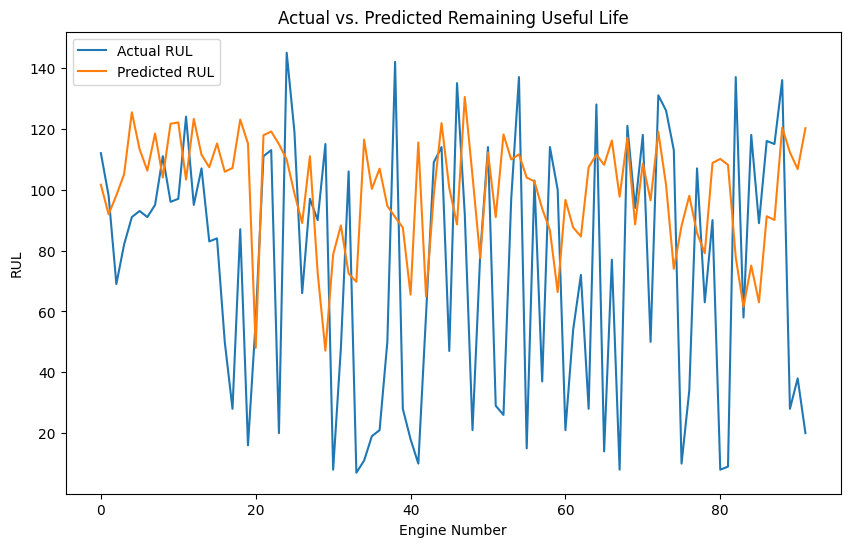

In [85]:
# Visualization - Plot actual vs. predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(rul_data.values, label='Actual RUL')
plt.plot(agg_predictions, label='Predicted RUL')
plt.title('Actual vs. Predicted Remaining Useful Life')
plt.xlabel('Engine Number')
plt.ylabel('RUL')
plt.legend()
plt.show()

# Conclusion

In this notebook, a predictive maintenance model was built using the FD001 dataset. An LSTM model was trained to predict the Remaining Useful Life (RUL) of engines based on their sensor readings and operational settings. The model was evaluated using RMSE and R² scores, and the results were visualized to compare the actual vs. predicted RUL.
